In [863]:
import pandas as pd
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt 
import datetime as dt
import re

In [864]:
data = pd.read_csv('matala2_cosmetics_2019-Nov.csv')
data.head()
data.info()

c:\Users\yona\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   event_time     1048575 non-null  object
 1   event_type     1048575 non-null  object
 2   product_id     1048575 non-null  int64 
 3   category_id    1048575 non-null  int64 
 4   category_code  16715 non-null    object
 5   brand          602451 non-null   object
 6   price          1048575 non-null  object
 7   user_id        1048575 non-null  int64 
 8   user_session   1048357 non-null  object
dtypes: int64(3), object(6)
memory usage: 72.0+ MB


In [865]:

data = data.loc[data['user_id'].isin([203531121, 562076640])]
data

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:02,view,5802432,1487580009286590000,NaN,NaN,0.32,562076640,09fafd6c-6c99-46b1-834f-33527f4de241
6,2019-11-01 00:00:25,view,5856189,1487580009026550000,NaN,runail,15.71,562076640,09fafd6c-6c99-46b1-834f-33527f4de241
12,2019-11-01 00:00:50,view,5856190,1487580009026550000,NaN,runail,15.71,562076640,09fafd6c-6c99-46b1-834f-33527f4de241
15,2019-11-01 00:00:57,view,5674484,1487580009026550000,NaN,runail,15.71,562076640,09fafd6c-6c99-46b1-834f-33527f4de241
53,2019-11-01 00:03:44,cart,5674484,1487580009026550000,NaN,runail,15.71,562076640,09fafd6c-6c99-46b1-834f-33527f4de241
55,2019-11-01 00:03:46,view,5856190,1487580009026550000,NaN,runail,15.71,562076640,09fafd6c-6c99-46b1-834f-33527f4de241
56,2019-11-01 00:03:54,view,5856189,1487580009026550000,NaN,runail,15.71,562076640,09fafd6c-6c99-46b1-834f-33527f4de241
80,2019-11-01 00:05:02,view,5896424,1487580006300250000,NaN,jessnail,32.54,562076640,09fafd6c-6c99-46b1-834f-33527f4de241
31270,2019-11-01 09:21:54,view,5895424,2154396123597370000,NaN,levrana,7.94,203531121,6f673fc9-aee4-437b-aabd-03a0f01127a5
31398,2019-11-01 09:23:01,view,5895425,2154396123597370000,NaN,levrana,7.94,203531121,6f673fc9-aee4-437b-aabd-03a0f01127a5


In [866]:
data = data[data['user_session'].notnull()]

In [867]:
data['event_time'] = data['event_time'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 0 to 1030055
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   event_time     17 non-null     datetime64[ns]
 1   event_type     17 non-null     object        
 2   product_id     17 non-null     int64         
 3   category_id    17 non-null     int64         
 4   category_code  0 non-null      object        
 5   brand          13 non-null     object        
 6   price          17 non-null     object        
 7   user_id        17 non-null     int64         
 8   user_session   17 non-null     object        
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 1.3+ KB



**סעיף 1**

In [868]:
data = data.sort_values(['user_session', 'event_time'], ascending=[True, True])
data['duration_to_next_event'] = data.groupby('user_session')['event_time'].diff(-1).dt.total_seconds().fillna(0)
data.loc[data.groupby('user_session').tail(1).index, 'duration_to_next_event'] = 0
data['duration_to_next_event'] = data['duration_to_next_event'].abs()

**סעיף 2**

In [869]:
data = data.sort_values(['user_id', 'event_time'], ascending=[True, True])
data['diff_for_funnel'] = data.groupby('user_id')['event_time'].diff()
data['funnel_number'] = (data['diff_for_funnel'] > pd.Timedelta(days=5)).groupby(data['user_id']).cumsum()
data['funnel_number'] = data['funnel_number'].fillna(0) + 1

**סעיף 3**

In [870]:
data['index_in_funnel'] = data.groupby(['user_id','funnel_number'])['user_session'].transform('nunique')

**סעיף 4**

לגבי הסעיף הזה שמתי לב כשאני מנסה להעיף את התבים שהם לא מספר בעמודה מחיר הפקודה היה מוחק לי חלק מהערכים התקינים 
 אז בחרתי לייצר דאטה פראם חדש שכוללת רק את הערכים הלא תקינים ,לעיף את התבים שהם לא מספר ואז להחליף את השורות האלה בדאטה פראם המקורי עם השורות של הדאטה פראם שעבדתי עליו.


In [872]:
data_with_letter_in_price = data[data['price'].str.contains(r'[^\d.]', na=False)]
data_with_letter_in_price['price'] = data_with_letter_in_price['price'].str.extract(r'(\d+\.?\d*)', expand=False)
data.update(data_with_letter_in_price)
data['price'] = data['price'].astype(float)

**סעיף 5**

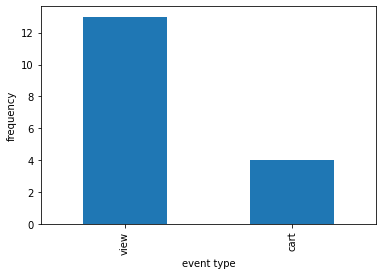

In [873]:
data['event_type'].value_counts().plot(kind='bar', xlabel='event type', ylabel='frequency')
plt.show()

**סעיף 6**

In [874]:
#CREATE A NEW DATAFRAME
session_data = data.loc[:, ['user_id', 'user_session', 'funnel_number','index_in_funnel']].drop_duplicates()


In [875]:
#COUNT num of event for session
datacounts = data.groupby('user_session')['event_time'].count()
session_data ['num_of_event'] = session_data ['user_session'].map(datacounts)

In [876]:
#TIME of event for session
datatime = data.groupby('user_session')['event_time'].apply(lambda x: x.max() - x.min())
session_data ['connection_time'] = session_data ['user_session'].map(datatime)


In [877]:
#PRODUCT ID view for session
view_products_list = data[data['event_type'] == 'view'].groupby('user_session')['product_id'].agg(list)
session_data['list_of_viewed'] = session_data ['user_session'].map(view_products_list)

In [878]:
#PRODUCT ID cart for session
cart_products_list = data[data['event_type'] == 'cart'].groupby('user_session')['product_id'].agg(list)
session_data['list_of_added_to_cart'] = session_data ['user_session'].map(cart_products_list)

In [879]:
#PRODUCT ID purchase for session
purchases_products_list = data[data['event_type'] == 'purchase'].groupby('user_session')['product_id'].agg(list)
session_data['list_of_purchased'] = session_data ['user_session'].map(purchases_products_list)

In [881]:
session_data

,user_id,user_session,funnel_number,index_in_funnel,num_of_event,connection_time,list_of_viewed,list_of_added_to_cart,list_of_purchased
31270,203531121,6f673fc9-aee4-437b-aabd-03a0f01127a5,1,1,2,0 days 00:01:07,"[5895424, 5895425]",NaN,NaN
908289,203531121,7bfa8be2-d1db-43bd-8801-a0b13b8a4618,2,2,3,0 days 00:01:49,NaN,"[5826721, 5830332, 5799080]",NaN
1029605,203531121,de1016fe-0b5b-4bd1-a17c-1533fe21ecb5,2,2,3,0 days 00:02:37,"[5799080, 5823656, 5826721]",NaN,NaN
0,562076640,09fafd6c-6c99-46b1-834f-33527f4de241,1,2,8,0 days 00:05:00,"[5802432, 5856189, 5856190, 5674484, 5856190, ...",[5674484],NaN
347434,562076640,b521c533-b482-4590-948e-e69403b58daf,1,2,1,0 days 00:00:00,[5854835],NaN,NaN
